# Анализ бизнес-показателей приложения

Мы работаем в развлекательном приложении Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

## Цель проекта 
Изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

##  Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Загрузка данных

Импортируем необходимые библиотеки для работы

In [2]:
import pandas as pd #import pandas
import os #import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

Пропишем пути к исходным файлам с данными 

In [3]:
pth_1_to_visits = 'D:/_THIS IS MY FOLDER/Я.Практикум, аналитика/Проекты/visits_info_short.csv'
pth_2_to_visits = '/datasets/visits_info_short.csv'
    
if os.path.exists(pth_1_to_visits):
        visits = pd.read_csv(pth_1_to_visits)
elif os.path.exists(pth_2_to_visits):
        visits = pd.read_csv(pth_2_to_visits)
else:
    print('Something is wrong')  

In [4]:
pth_1_to_orders = 'D:\_THIS IS MY FOLDER\Я.Практикум, аналитика\Проекты\orders_info_short.csv'
pth_2_to_orders = '/datasets/orders_info_short.csv'
    
if os.path.exists(pth_1_to_orders):
        orders = pd.read_csv(pth_1_to_orders)
elif os.path.exists(pth_2_to_orders):
        orders = pd.read_csv(pth_2_to_orders)
else:
    print('Something is wrong')  

In [5]:
pth_1_to_costs = 'D:/_THIS IS MY FOLDER/Я.Практикум, аналитика/Проекты/costs_info_short.csv'
pth_2_to_costs = '/datasets/costs_info_short.csv'
    
if os.path.exists(pth_1_to_costs):
        costs = pd.read_csv(pth_1_to_costs)
elif os.path.exists(pth_2_to_costs):
        costs = pd.read_csv(pth_2_to_costs)
else:
    print('Something is wrong') 

In [6]:
def data_info(df):
    print(f'Размер таблицы {df.shape}')
    
    df.info()

    print(f'Количество дубликатов {df.duplicated().sum()}')

In [7]:
data_info(visits)

Размер таблицы (309901, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
Количество дубликатов 0


Пропусков тоже нет. Данные в столбцах `session start` и `session end` нужно привести к типу datetime. Также необходимо переименовать столбцы в соответствии с правилами хорошего стиля.

In [11]:
#переименуем столбцы в данных о визитах
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

#приведем данные в столбцах session start и session end к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [12]:
#выведем на экран данные о заказах
data_info(orders)

Размер таблицы (40212, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
Количество дубликатов 0


Пропусков тоже нет. Данные в столбце `Event DT` нужно привести к типу datetime

In [13]:
#переименуем столбцы в данных о заказах
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

In [14]:
#приведем данные в столбце event_dt типу datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [15]:
#выведем на экран данные о расходах
data_info(costs)

Размер таблицы (1800, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB
Количество дубликатов 0


Данные в столбце `dt` нужно привести к типу datetime

In [10]:
#переименуем столбцы в данных о расходах
costs = costs.rename(columns=
                     {'Channel' : 'channel'}) 


#приведем данные в столбце dt к типу datetime
costs['dt'] = pd.to_datetime(costs['dt'])

### Вывод

- В исходных данных есть нарушения в наименовании колонок: они заданы с нарушением правил хорошего стиля
- В исходных данных в столбцах с информацией о времени тип данных был задан datetime
- В исходных данных нет дубликатов
- В исходных данных нет пропущенных значений

# Функции LTV, ROI, удержания и конверсии

In [16]:
# функция для получения пользовательских профилей
def get_profiles(sessions, orders):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверьте, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique()) # ваш код здесь

    return profiles

#функция для расчёта удержания
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

#функция для расчета конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 


# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
    
    
    
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
    
    

Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Построим профили пользователей.

In [17]:
profiles = get_profiles(visits, orders)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False


Определим минимальную и максимальную дату привлечения пользователей

In [23]:
#минимальная дата привлечения
print('Минимальная дата привлечения', profiles['first_ts'].min())

#максимальная дата привлечения
print('Максимальная дата привлечения', profiles['first_ts'].max())

Минимальная дата привлечения 2019-05-01 00:00:41
Максимальная дата привлечения 2019-10-27 23:59:04


Пользователи привлекались с 1 мая 2019 года по 27 октября 2019 года.

Определим, из каких стран приходят пользователи и на какую страну приходится бОльшая доля платящих пользователей.

In [24]:
#группируем данные по столбцу "region", считаем для каждого девайса количество пользователей,
#количество платящих пользователей и отношение платящих к неплатящим

(
    profiles.pivot_table(
    index = 'region',
    values = 'payer',
    aggfunc = ['sum', 'count', 'mean'])
    .reset_index()
    .rename(columns = {'sum': 'paying_users', 'count': 'all_users', 'mean': 'ratio'})
    .droplevel(1, axis=1)
    .sort_values(by = 'ratio', ascending = False)
    .style.format({'ratio': '{:.2%}'})
    .hide_index()
    .highlight_max(color='lightgreen')
)

C:\Users\masya\AppData\Local\Temp\ipykernel_5388\2147942859.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  .hide_index()


region,paying_users,all_users,ratio
United States,6902,100002,6.90%
Germany,616,14981,4.11%
UK,700,17575,3.98%
France,663,17450,3.80%


У нас есть данные о пользователях из Германии, Франции, Великобритании и США. Больше всего платящих пользователей в США.

Определим, какими устройствами пользуются клиенты.

In [25]:
#группируем данные по столбцу "device", считаем для каждого девайса количество пользователей,
#количество платящих пользователей и отношение платящих к неплатящим

(
    profiles.pivot_table(
    index = 'device',
    values = 'payer',
    aggfunc = ['sum', 'count', 'mean'])
    .reset_index()
    .rename(columns = {'sum': 'paying_users', 'count': 'all_users', 'mean': 'ratio'})
    .droplevel(1, axis=1)
    .sort_values(by = 'ratio', ascending = False)
    .style.format({'ratio': '{:.2%}'})
    .hide_index()
    .highlight_max(color='lightgreen')
)

C:\Users\masya\AppData\Local\Temp\ipykernel_5388\705956660.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  .hide_index()


device,paying_users,all_users,ratio
Mac,1912,30042,6.36%
iPhone,3382,54479,6.21%
Android,2050,35032,5.85%
PC,1537,30455,5.05%


Привлекаемые пользователи пользуются iPhonом, Androidом, ПК и Macом. Больше всего пользователей Айфонов. <br>
Самыми платящими пользователями являются пользователи Macов И Айфонов.

Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [26]:
#группируем данные по столбцу "channel", считаем для каждого девайса количество пользователей,
#количество платящих пользователей и отношение платящих к неплатящим

(
    profiles.pivot_table(
    index = 'channel',
    values = 'payer',
    aggfunc = ['sum', 'count', 'mean'])
    .reset_index()
    .rename(columns = {'sum': 'paying_users', 'count': 'all_users', 'mean': 'ratio'})
    .droplevel(1, axis=1)
    .sort_values(by = 'ratio', ascending = False)
    .style.format({'ratio': '{:.2%}'})
    .hide_index()
    .highlight_max(color='lightgreen')
)

C:\Users\masya\AppData\Local\Temp\ipykernel_5388\3654135934.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  .hide_index()


channel,paying_users,all_users,ratio
FaceBoom,3557,29144,12.20%
AdNonSense,440,3880,11.34%
lambdaMediaAds,225,2149,10.47%
TipTop,1878,19561,9.60%
RocketSuperAds,352,4448,7.91%
WahooNetBanner,453,8553,5.30%
YRabbit,165,4312,3.83%
MediaTornado,156,4364,3.57%
LeapBob,262,8553,3.06%
OppleCreativeMedia,233,8605,2.71%


Пользователи в Procrastinate Pro+ привлекаются по 10 рекламным каналам: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds,
WahooNetBanner,YRabbit, MediaTornado, LeapBob, OppleCreativeMedia. <br> 
Также есть ещё пользователи из органического трафика. Их большинство. Но среди них самое малое количество платящих пользователей.<br>
Из всех платных каналов привлечения больше всего покупателей приносит FaceBoom.

### Вывод

- Рекламные вложения в новых пользователей были  с 1 мая 2019 года по 27 октября 2019 года.
- Пользователи привлекаются из Германии, Франции, Великобритании и США. Самыми платящими пользователями являются пользователи из США и они лучше конвертируются.
- Привлекаемые пользователи пользуются iPhonом, Androidом, ПК и Macом. Самыми платящими пользователями являются пользователи Macов.
- При этом большая часть пользователей заходит с мобильных устройств, это тоже стоит отметить. 
- В целом пользователи Apple имеют лучшую конверсию в покупателей. Возможно, тут есть плюсы ApplePay.
- Пользователи привлекаются через следующие рекламные каналы: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds, WahooNetBanner,YRabbit, MediaTornado, LeapBob, OppleCreativeMedia. Из всех платных каналов привлечения больше всего покупателей приносит FaceBoom.

# Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Посчитаем, сколько всего денег мы потратили на рекламу.

In [27]:
sum_costs_adv = costs['costs'].sum()
f"Всего потрачено на рекламу {sum_costs_adv:.2f}"

'Всего потрачено на рекламу 105497.30'

Посчитаем затраты на каждый из источников привлечения

<AxesSubplot:xlabel='channel'>

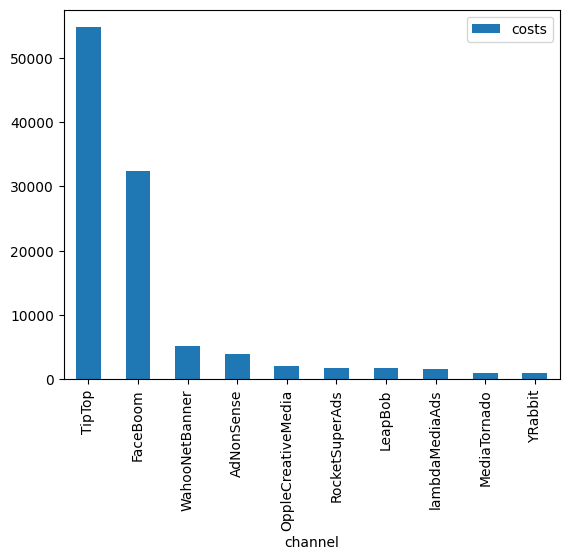

In [28]:
#сгруппируем данные из датасета costs по источнику привлечения
#и посчитаем для каждого источника сумму затрат
ad_costs = (
    costs.groupby('channel')
    .agg({'costs': 'sum'})
    .sort_values(by = 'costs', ascending = False)
)

#построим по получившейся таблице гистограмму для удобства восприятия
ad_costs.plot.bar()

Больше всего затрат на рекламу в TipTop. Меньше всего потрачено на рекламу в YRabbit.

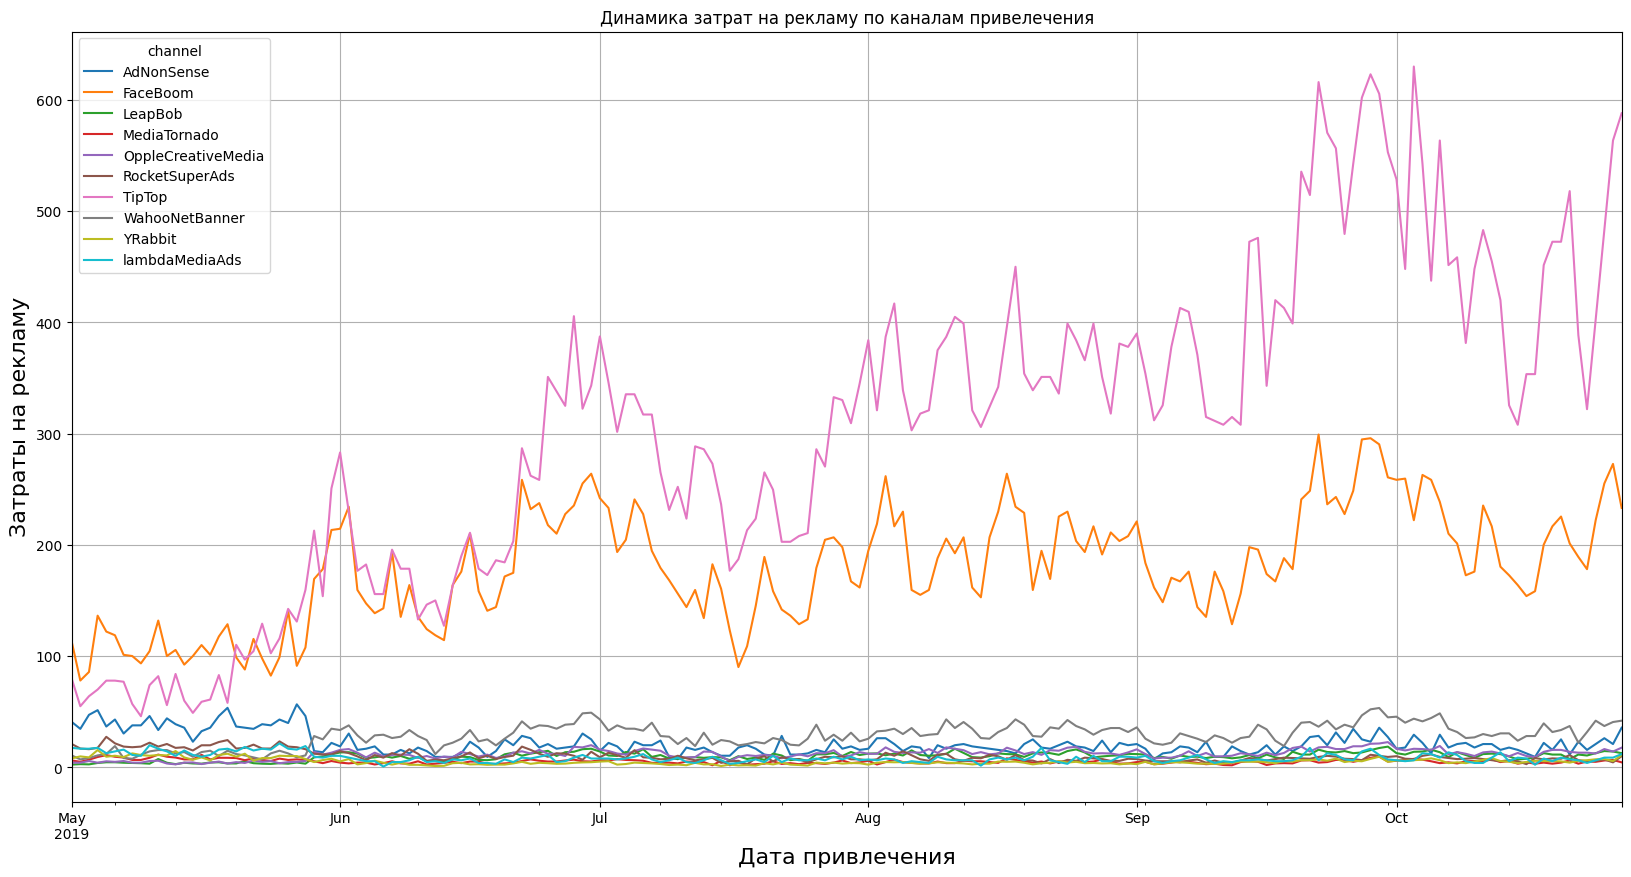

In [29]:

(costs.pivot_table(
    index='dt',
    columns='channel',
    values = 'costs',
    aggfunc = 'sum')
    .plot(grid=True, figsize=(20, 10))
)
plt.ylabel('Затраты на рекламу',  fontsize=16)
plt.xlabel('Дата привлечения',  fontsize=16)
plt.title('Динамика затрат на рекламу по каналам привелечения')
plt.show()
       


Посчитаем, сколько мы потратили на рекламу во времени и визуализируем эти данные.

In [31]:
#сделаем сводную таблицу, в которой объединим данные по столбцу "dt" - дата
# и для каждого значения даты посчитаем суммарные затраты на рекламу
costs_grouped_by_date = (
    costs.groupby('dt')
    .agg({'costs': 'sum'})
)

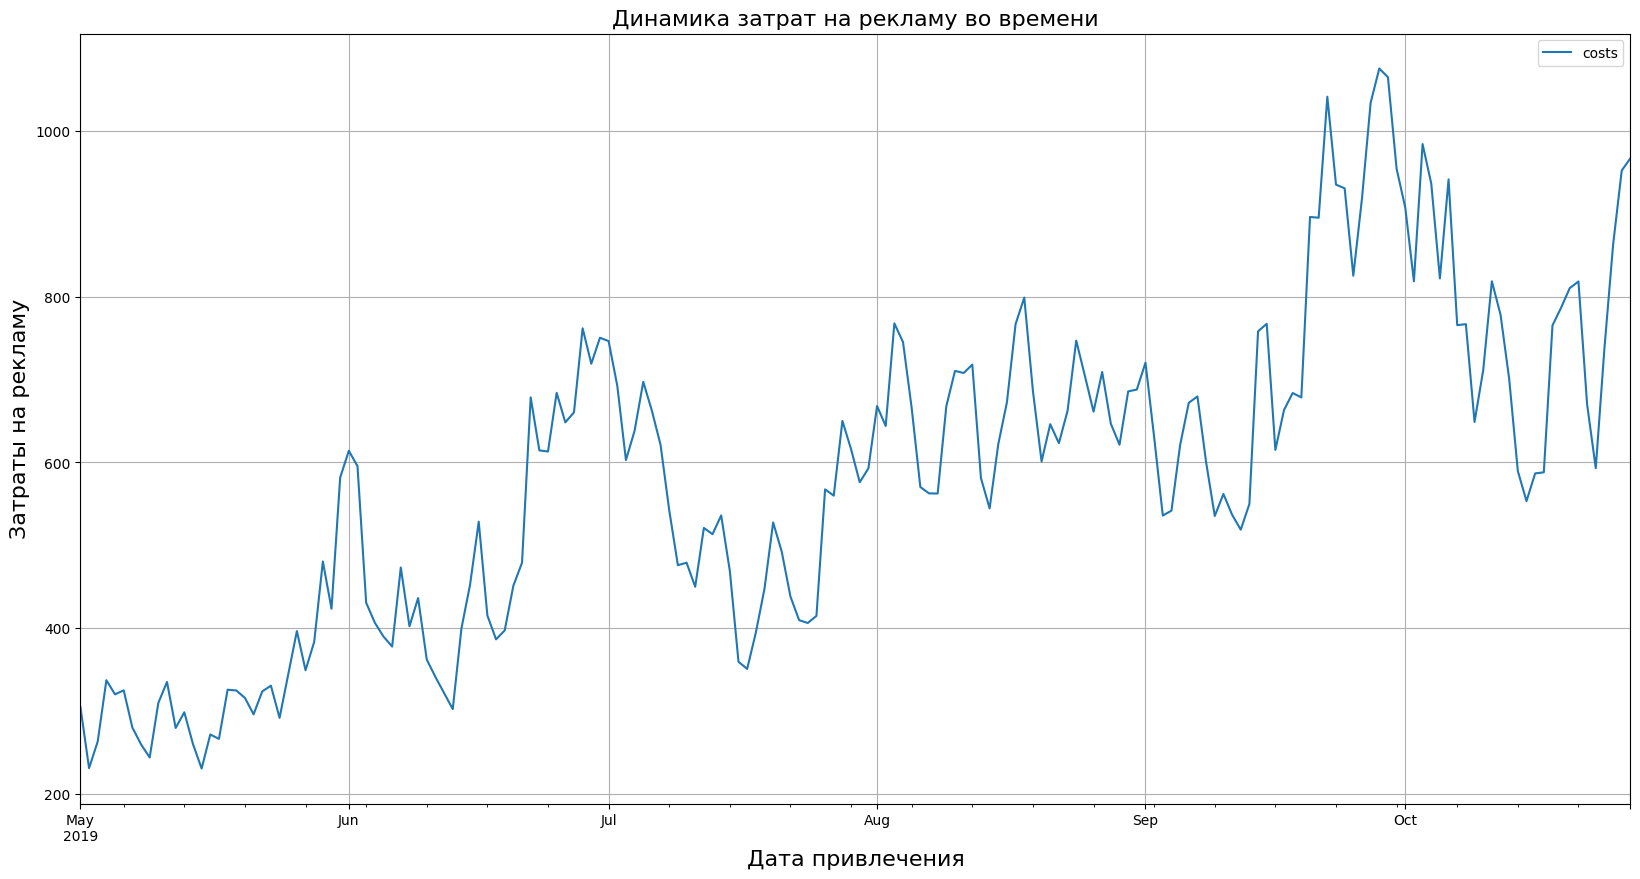

In [32]:
#построим по получившейся сводной таблице график 
costs_grouped_by_date.plot(grid=True, figsize=(20, 10))
plt.ylabel('Затраты на рекламу', fontsize=16)
plt.xlabel('Дата привлечения', fontsize=16)
plt.title('Динамика затрат на рекламу во времени', fontsize=16)
plt.show()

С мая по октябрь в среднем затраты на рекламу растут. Максимальные затраты на рекламу были с середины сентября по начало октября. <br>
Минимальные затраты на рекламу были в самом начале старта рекламной кампании: в мае 2019 года.<br>
График затрат на рекламу представлен не плавной линией, а с выраженными точками минимумов и максимумов. Возможно, в определенные дни (например, выходные) реклама показывалась меньше.

Узнаем, сколько в среднем стоило привлечение одного покупателя из каждого источника, посчитаем CAC 

In [33]:
# сортируем сессии по ID пользователя и дате привлечения
# группируем по ID и находим параметры первых посещений
profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

In [34]:
# для когортного анализа определяем дату первого посещения
# и первый день месяца, в который это посещение произошло
profiles['dt'] = profiles['first_ts'].dt.date
profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

# добавляем признак платящих пользователей
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

In [35]:
# считаем количество уникальных пользователей
# с одинаковыми источником и датой привлечения
new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

#преобразуем тип данных в столбце "dt" в datetime
new_users['dt'] = pd.to_datetime(new_users['dt'])

In [36]:
# объединяем траты на рекламу и число привлечённых пользователей
# по дате и каналу привлечения
ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

# делим рекламные расходы на число привлечённых пользователей
# результаты сохраним в столбец acquisition_cost (CAC)
ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

#преобразуем тип дынных в солбце "dt" к datetime
profiles['dt'] = pd.to_datetime(profiles['dt'])

In [37]:
# добавим стоимость привлечения в профили
profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'],how='left')
#заполним все NaNы на нули
profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


Посчитаем CAC для каждого из каналов привлечения пользователей

In [38]:
#сгруппируем данные из profiles по столбцу "channel" - канал привлечения
#для каждого из каналов посчитаем среднюю стоимость привлечения
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values('acquisition_cost', ascending=False)
    
)
cac['acquisition_cost']=round(cac['acquisition_cost'],2)

cac

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


На канал привлечения Tip Top тратится больше всего средств на привлечение одного пользователя. Самым дешевым платным каналом привлечения является LeapBob

In [39]:
#посчитаем средний CAC. Для этого разделим все затраты на рекламу (посчитаны выше) 
#на размер когорты (количество уникальных пользователей)
avg_cac = sum_costs_adv/profiles['user_id'].nunique()
avg_cac

0.703277825182657

Средняя стоимость привлечения каждого нового клиента в приложение по всем рекламным каналам обходится в 0,70

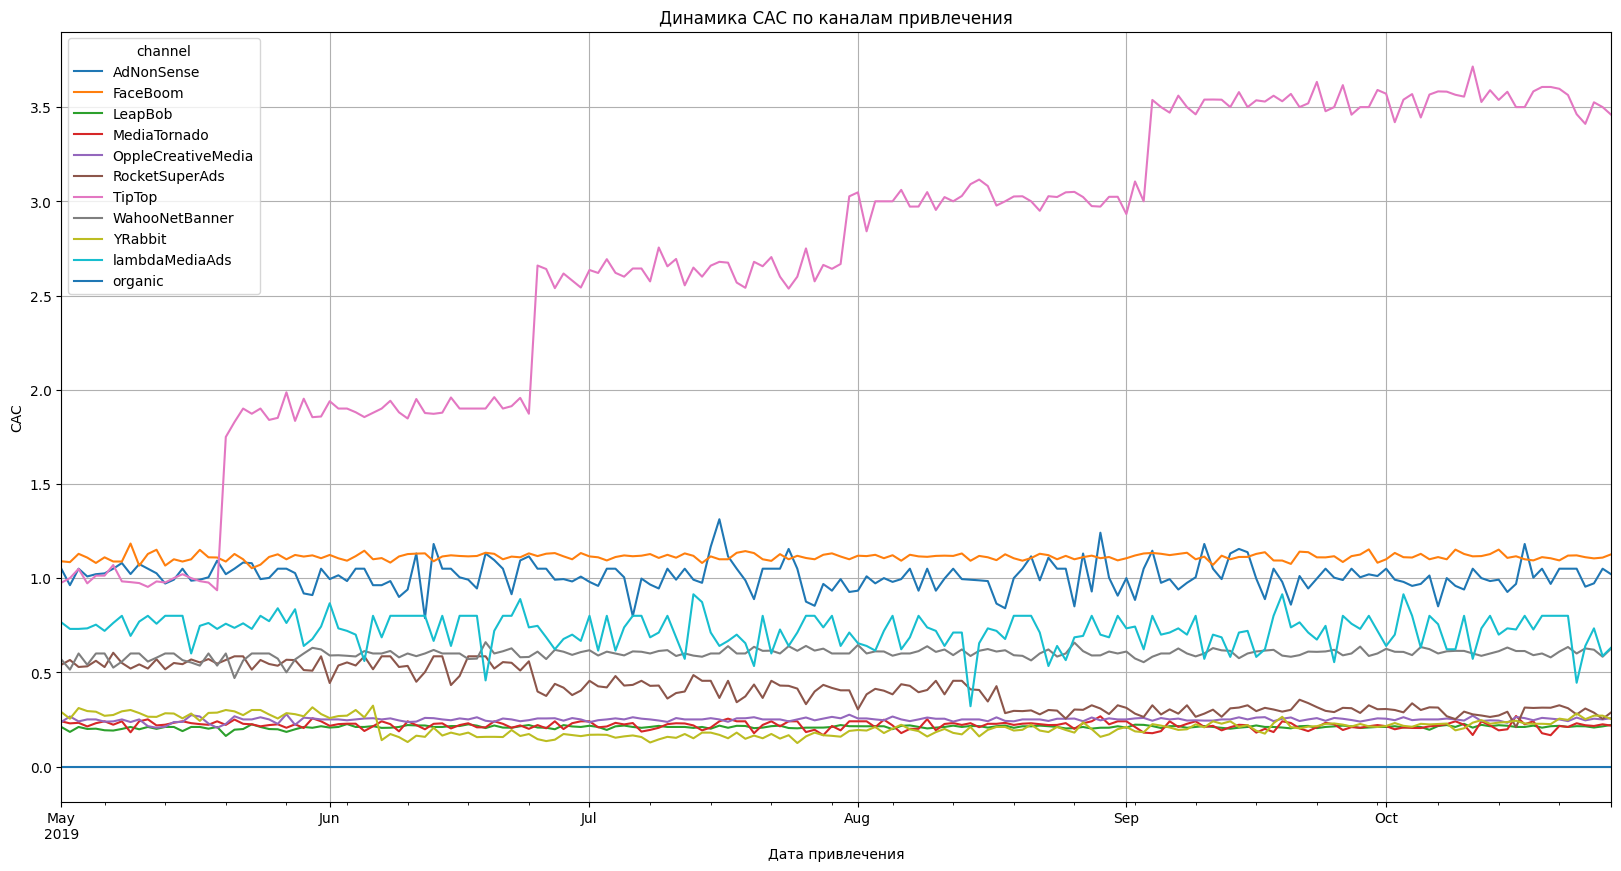

In [40]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Стоимость привлечения одного клиента по всем рекламным каналам в среднем за весь период рекламной кампании не меняется<br> Кроме как для TipTop. В этой рекламной сети CAC вырос во второй половине мая, в конце июня, в начале сентября. В эти периоды рекламодатель повышал затраты на рекламу в TipTop.<br>
Сейчас мы не можем сделать выводы о том, хороший ли это CAC или плохой, пока мы не посчитаем LTV.

### Вывод

- В рекламу приложения ProcrastinatePro+ было вложено 105 497,3 
- Больше всего затрат на рекламу в TipTop. Меньше всего потрачено на рекламу в YRabbit.
- С мая по октябрь в среднем затраты на рекламу растут. Максимальные затраты на рекламу были с середины сентября по начало октября.
- Средняя стоимость привлечения каждого нового клиента в приложение по всем рекламным каналам обходится в 0,70
- Самая большая стоимость привлечения нового клиента в приложения в рекламном канале TipTop (от 1,0 до 3,5).


# Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Установим момент и горизонт анализа данных. 

In [41]:
#момент анализа данных
observation_date = datetime(2019, 11, 1).date()

#горизонт анализа данных
horizon_days = 14

Удалим пользователей, которые пришли из органики, т.к. задача проианализировать рекламные расходы, а на органику компания не тратит ни копейки.

In [42]:
profiles = profiles.query('channel != "organic"')

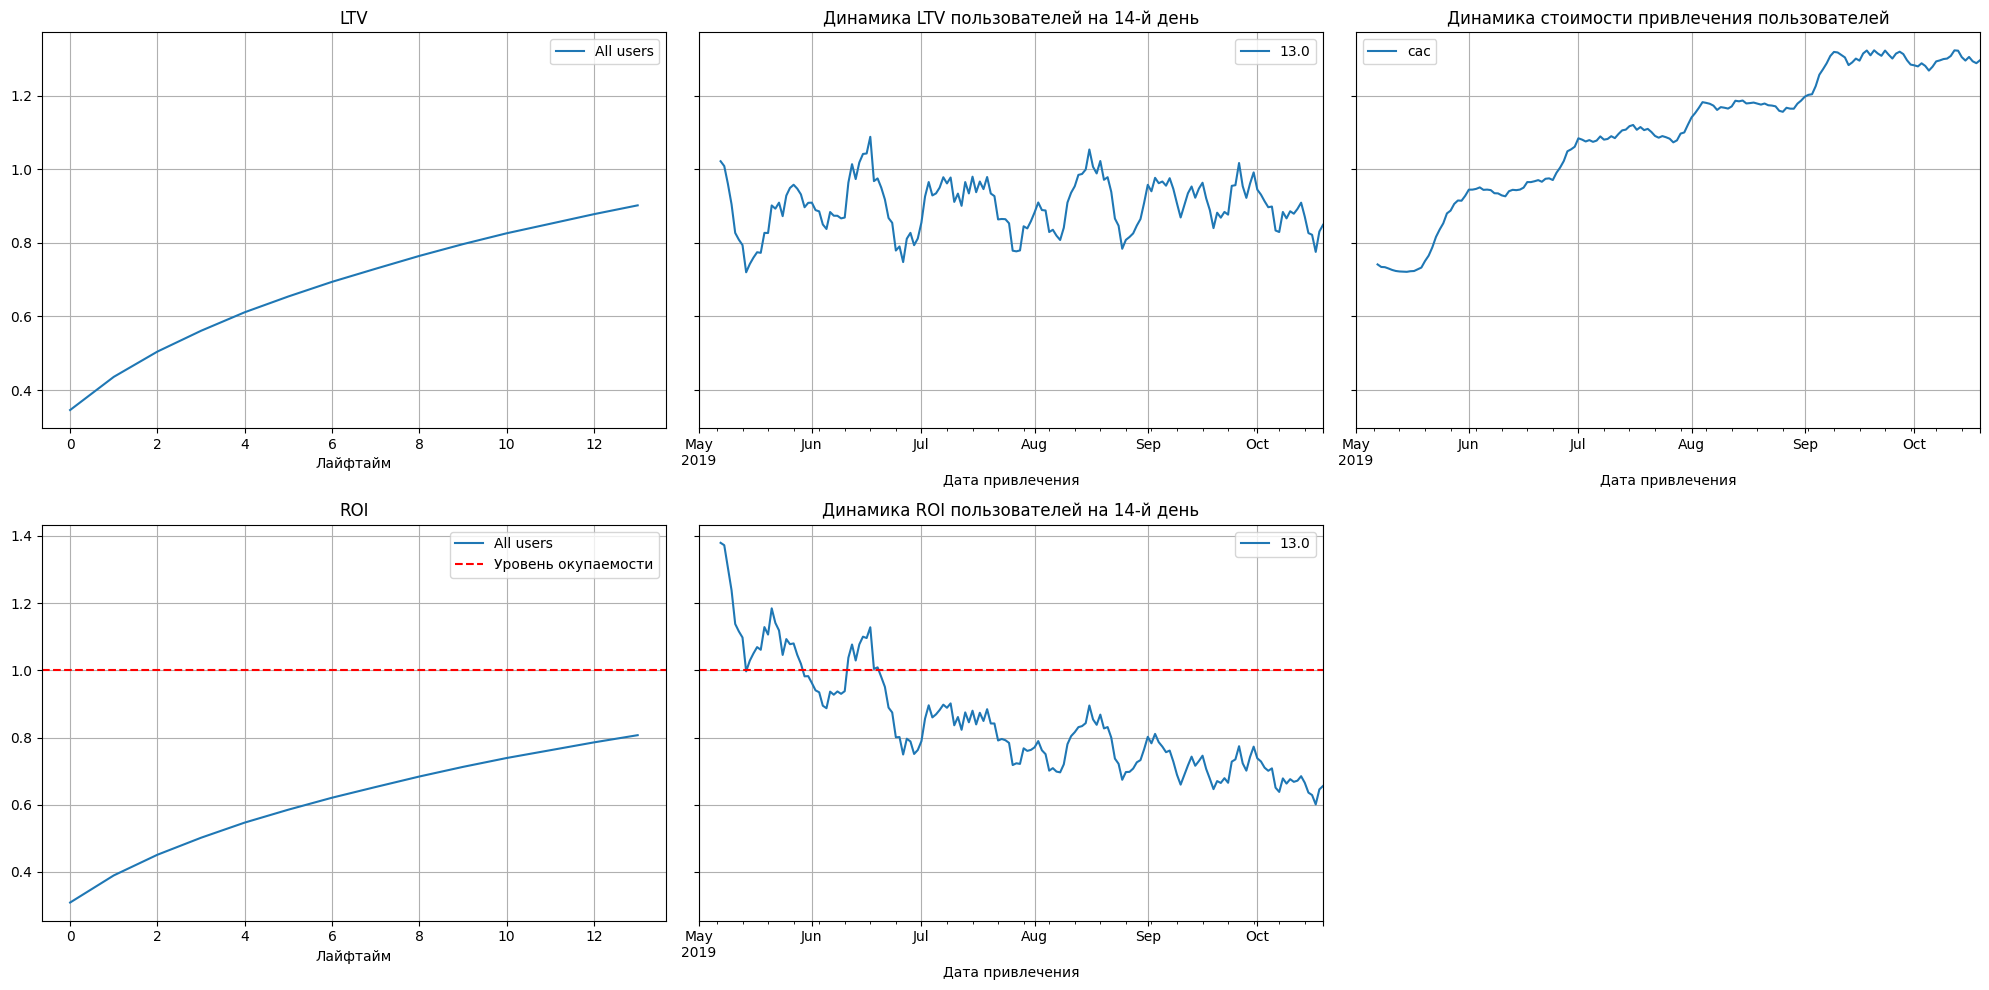

In [43]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

### Общая окупаемость рекламы

По общим графикам можно сделать следующие выводы:<br>
- ROI не окупается, он меньше 100 %; он хоть и растет, но не доходит до нужного уровня
- ROI пользователей 14-го дня постоянно снижается. С июня месяца новые пользователи перестают окупаться. Похоже, вложения не окупаются и прибыль компании снижается.
- CAC растет. С середины мая на начало июня CAC резко возрос. Далее со временем CAC все так же растет, и остается примерно на одном уровне с 10-х чисел сентября до конца рекламной кампании. Компания тратит со временем все больше и больше денег на привлечение новых пользователей.
- Линия LTV растёт.<br>

Похоже , что стоимость привлечения нового клиента перевешивает LTV для данного приложения.

### Окупаемость рекламы с разбивкой по устройствам

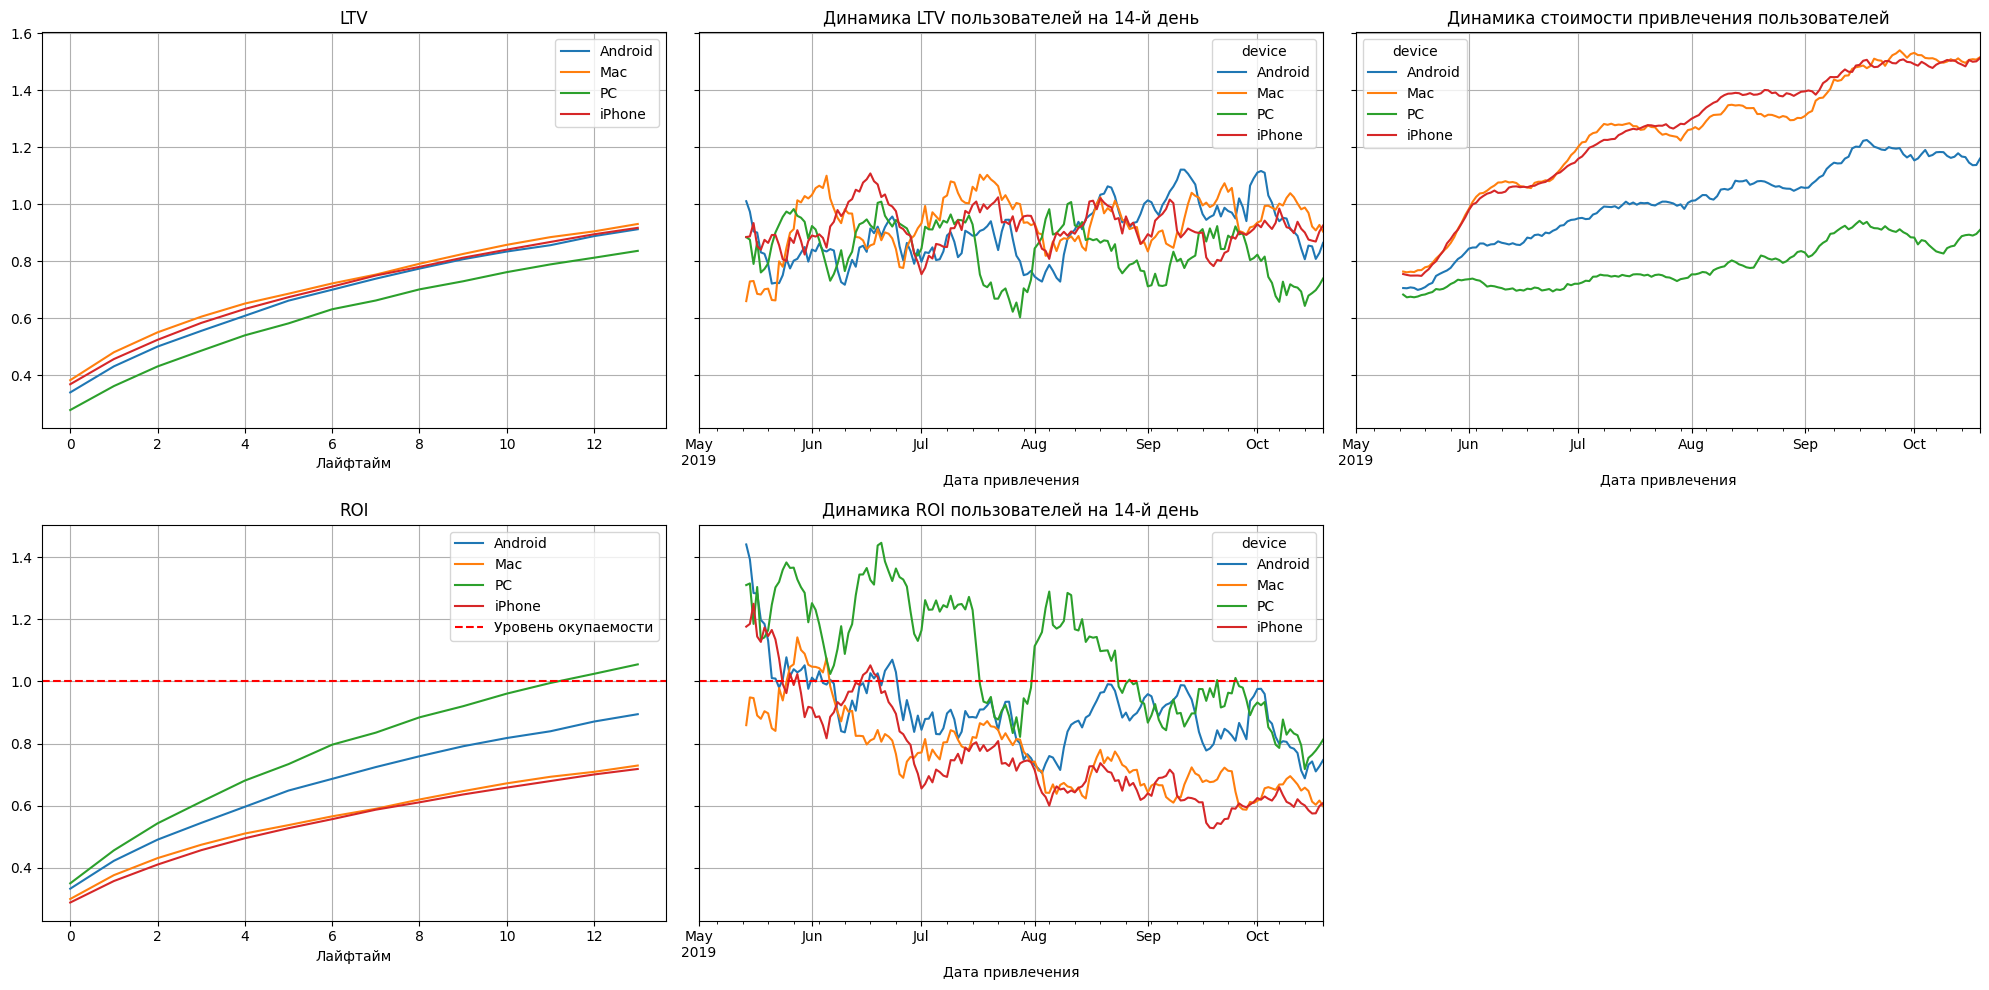

In [44]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Пользователи PC окупаются после 11 дня. Пользователи Android, iPhone и Mac - не окупаются.
- При этом самые большие затраты на привлечени каждого нового пользователя для iPhonов и Macов. Далее идут затраты на привлечение пользователей Androidов, а самые низкие затраты на привлечение пользователей PC. Тем не менее, затраты на пользователей всех устройств растут со временем
- Вложения в пользователей Android, iPhone и Mac 14-го дня перестают окупаться с июня месяца. Вложения в пользователей PC 14-го дня окупаются, но с середины августа перестают окупаться.
- Интересно, что на пользователей 14-го дня, использующих PC, компания с сентября стала вкладывать больше, а динамика ROI этих же пользователей с сентября вообще перестала окупаться. 

### Окупаемость рекламы с разбивкой по странам

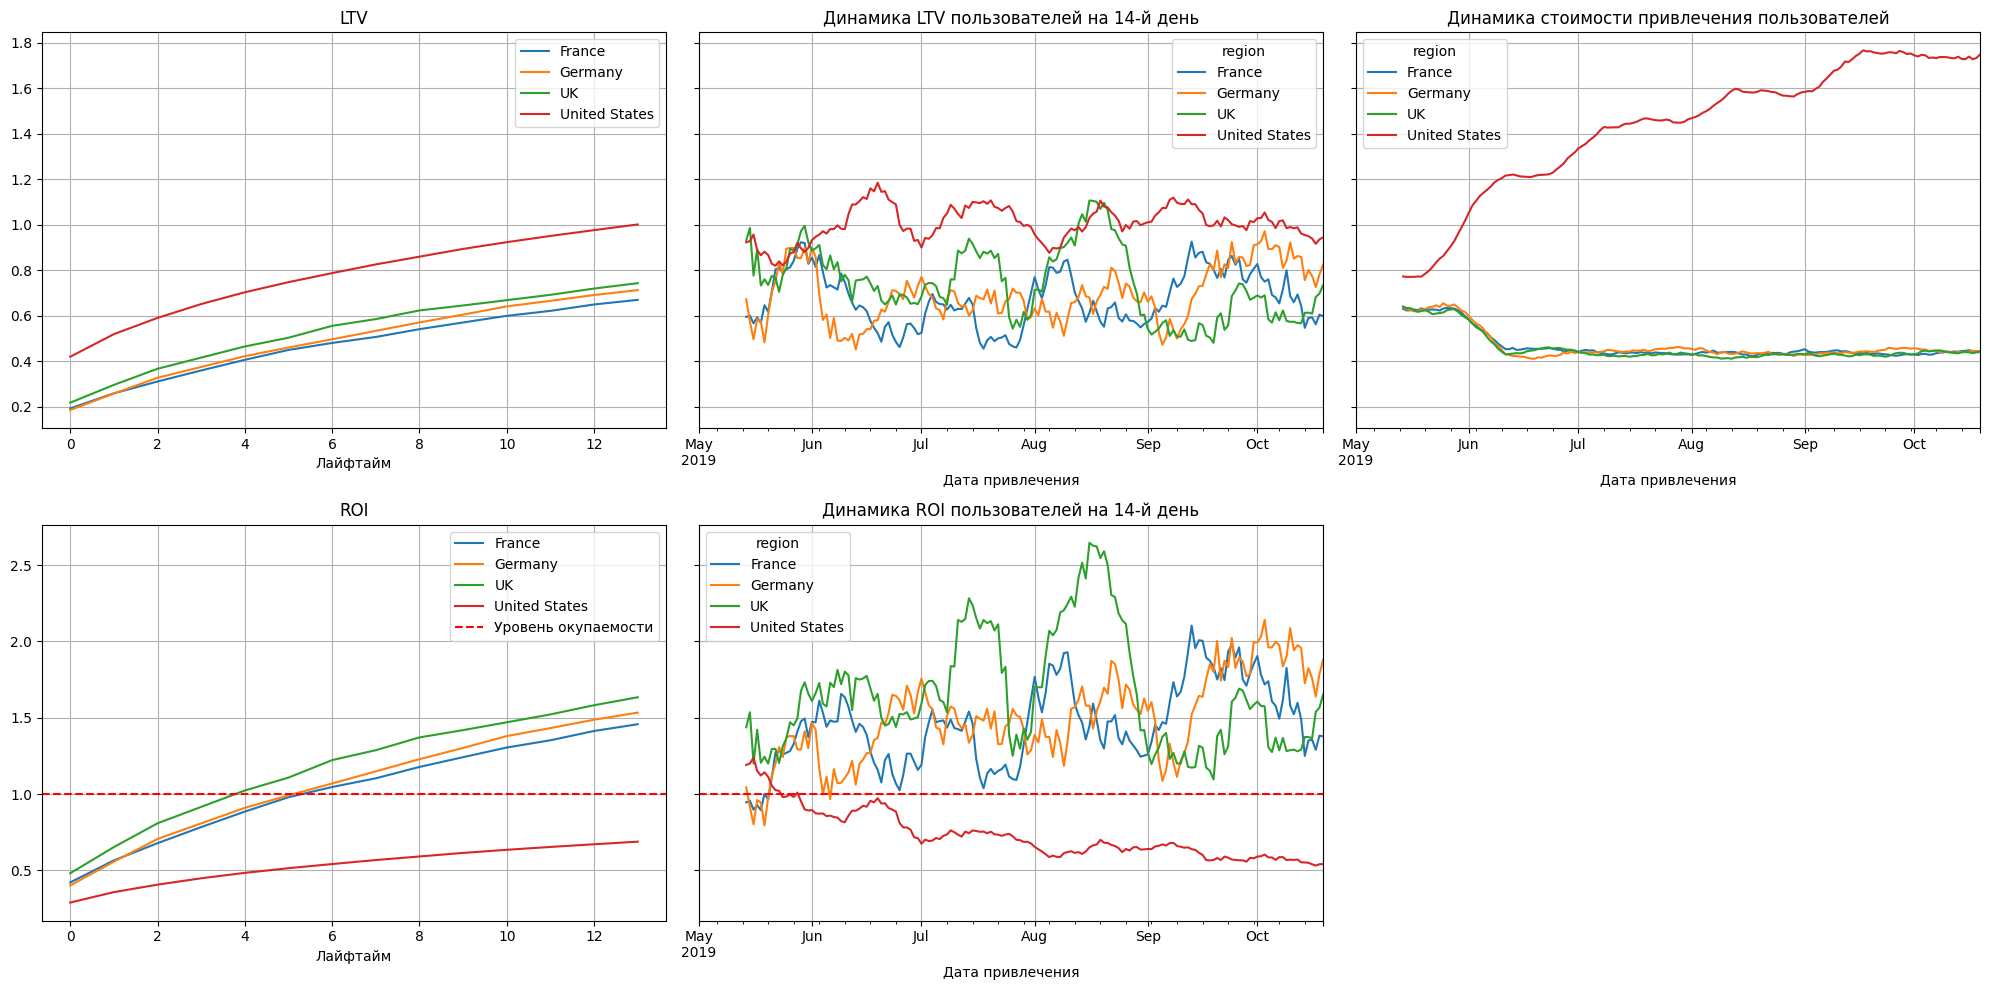

In [45]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Самый высокий LTV  у пользователей США. Затем идут Великобритания и Германия. Пользователи из Франции приносят приложению меньше всего выручки
- Самые большие затраты на привлечение пользователей из США, они со временемони растут, особенно резко затраты выросли в конце мая. Затраты на привлечение пользователей из остальных стран снизились с начала июня и остаются примерно на одном уровне.
- Пользователи из Франции, Германии, Великобритании окупаются. а пользователи из США - нет. 
- Пользователи из США 14-го дня не окупаются с конца мая.

### Окупаемость рекламы с разбивкой по рекламным каналам

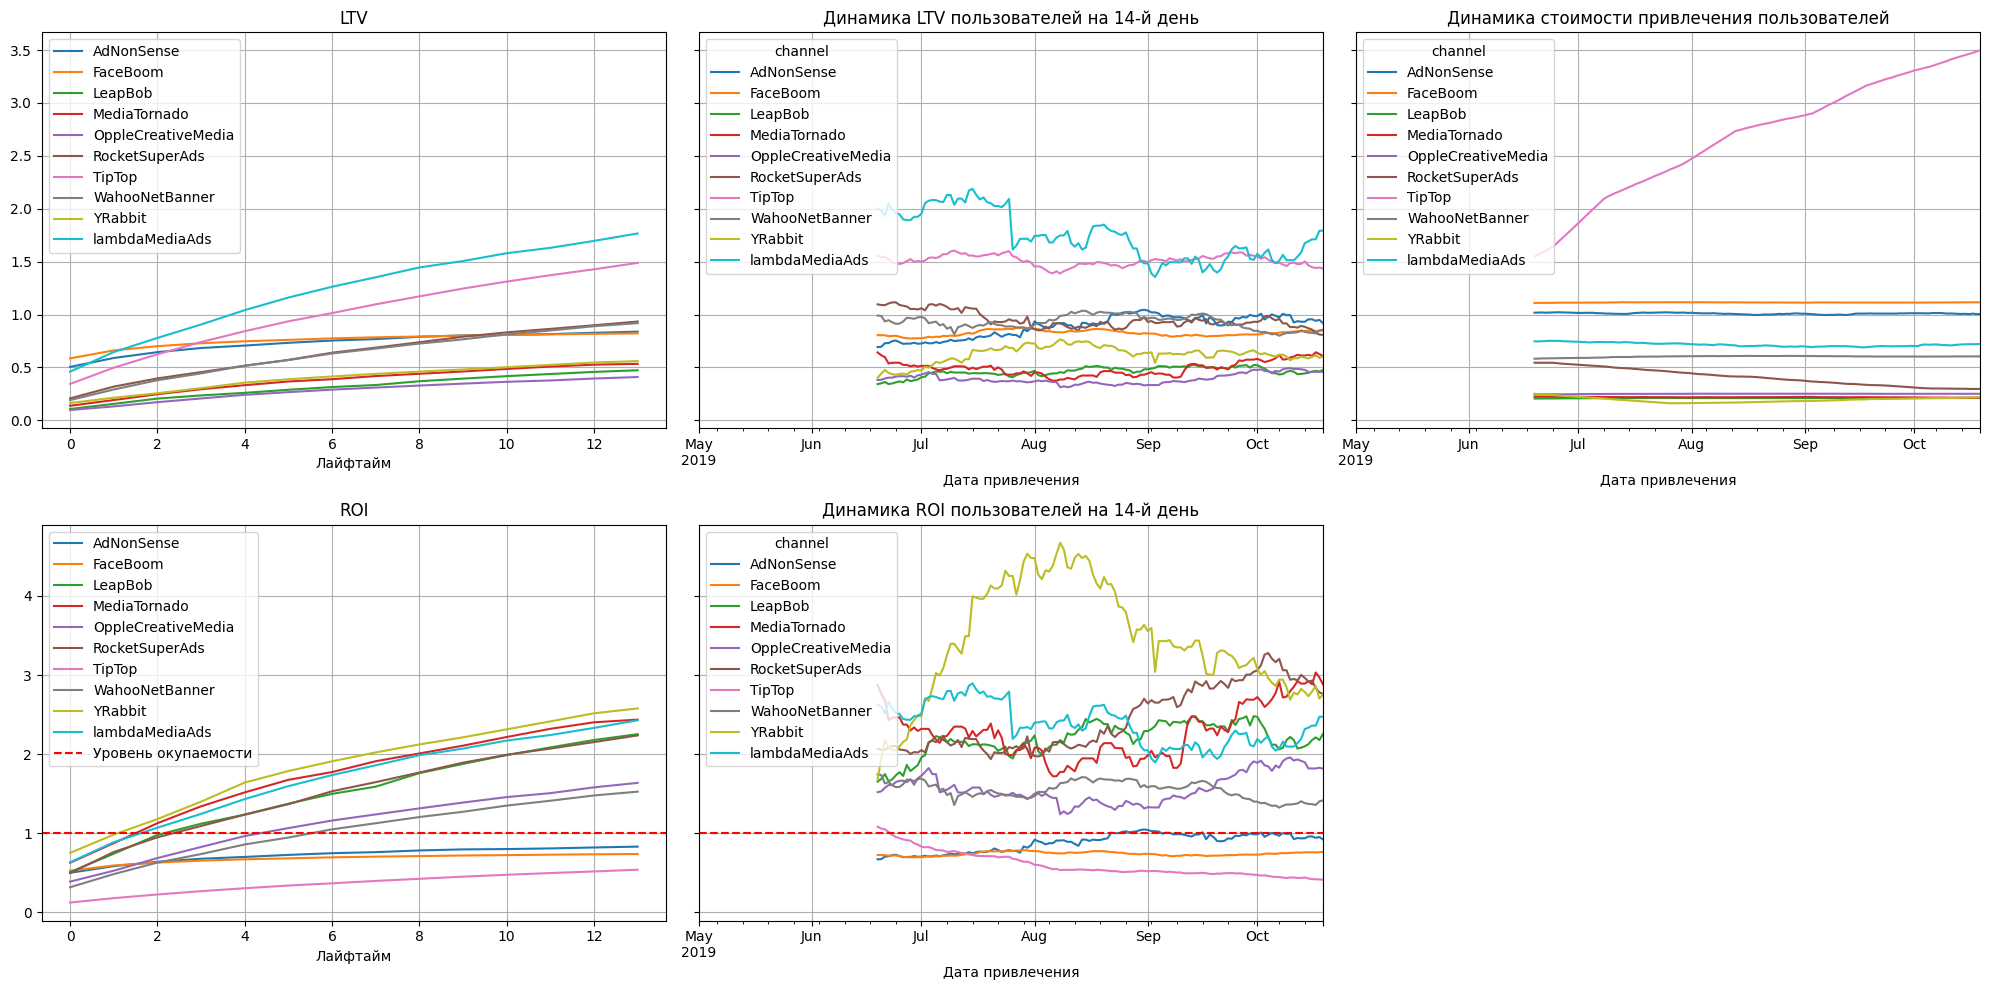

In [46]:
# смотрим окупаемость с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=50
) 

- Самые большие затраты на привлечение пользователей из TipTop
- Пользователи из TipTop, FaceBoom и lambdaMediaAds не окупаются.

Проверим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

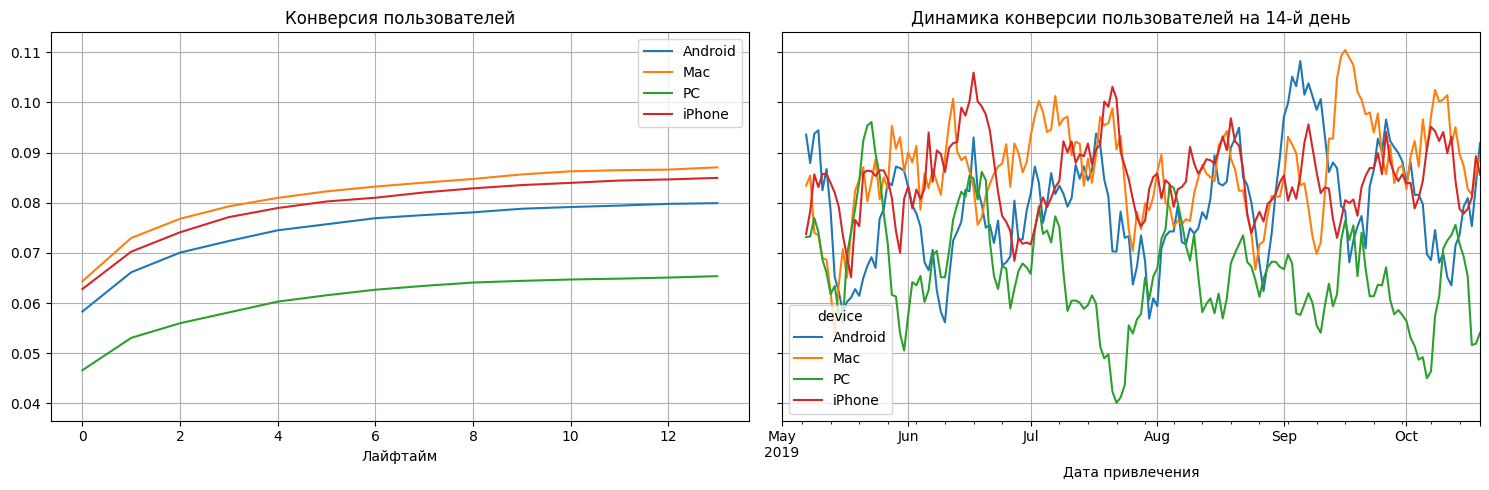

In [47]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- В целом конверсия пользователей всех девайсов растёт со временем. 
- Лучше всего конвертируются пользователи Mac и iPhone. Далее идут пользователи  Android. Хуже всех конвертируются пользователи PC.
- Конверсия пользователей 14-го дня по всем девайсам меняется во времени. Самая низкая конверсия для пользователей PC в середине июля. Самая низкая конверсия для пользователей Android в начале августа. Самая низкая конверсия для пользователей iPhone в самом начале рекламной кампании - в мае. Для пользователей Mac самая низкая конверсия тоже в мае.
- Пользователи Mac и iPhone не всегда конвертировались лучше остальных. Так, пользователи Android, привлеченные в начале сентября показывали большую конвертацию 14-го дня.

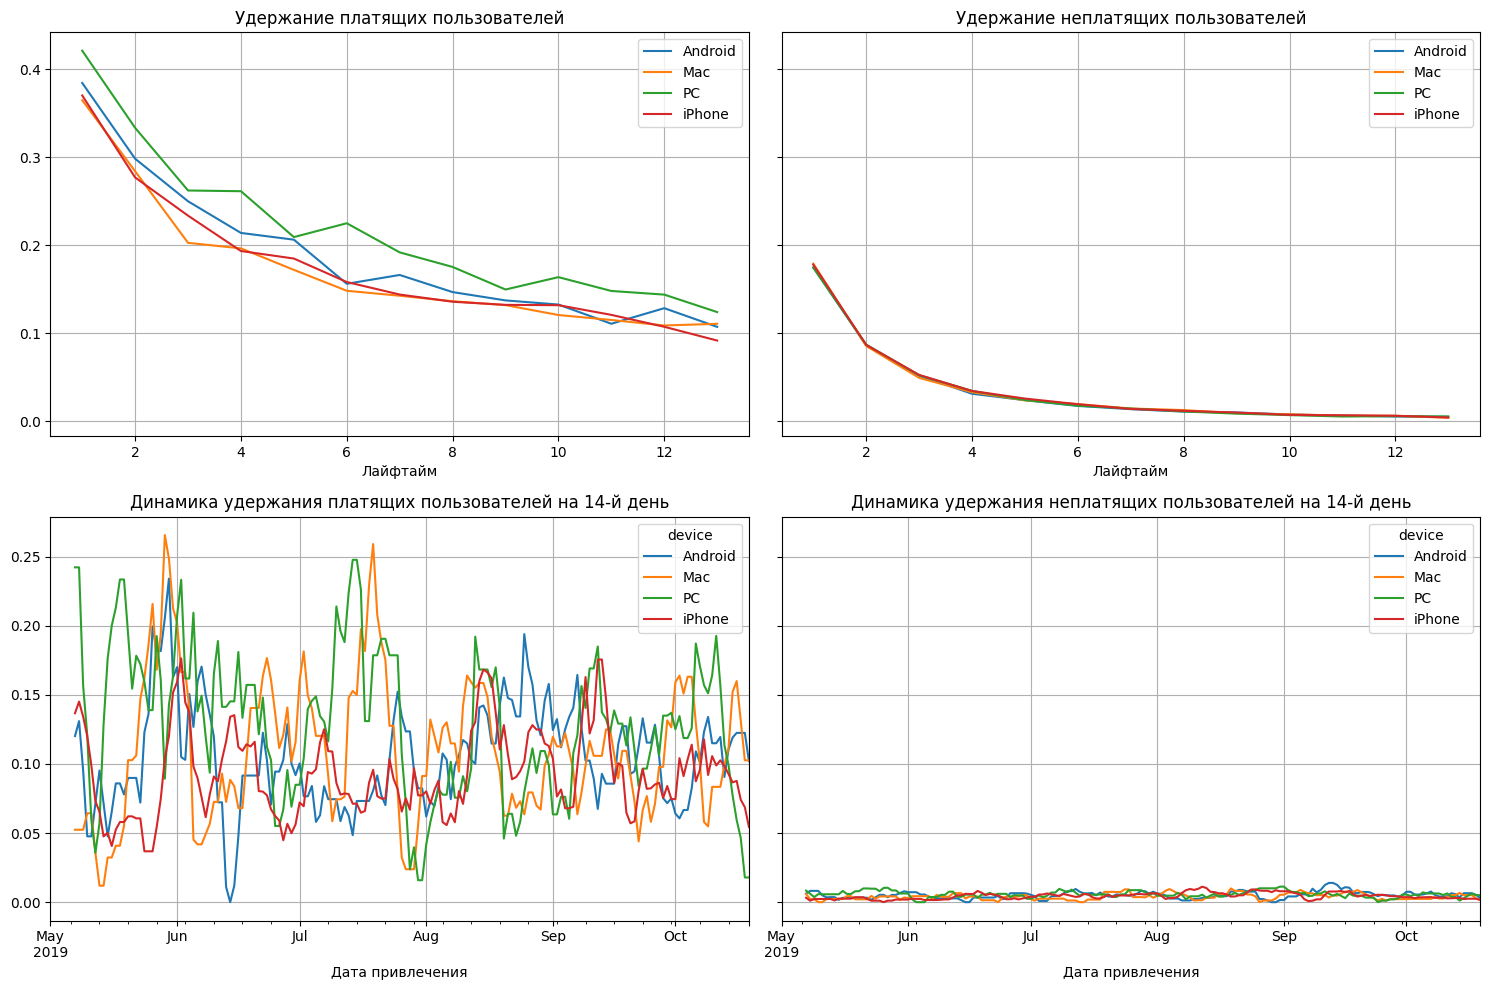

In [48]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Самое высокое удержание платящих пользователей PC, далее идут пользователи Android. Хуже всего удерживаются пользователи  iPhone И Mac.
- Удержание платящих пользователй лучше, чем неплатящих.

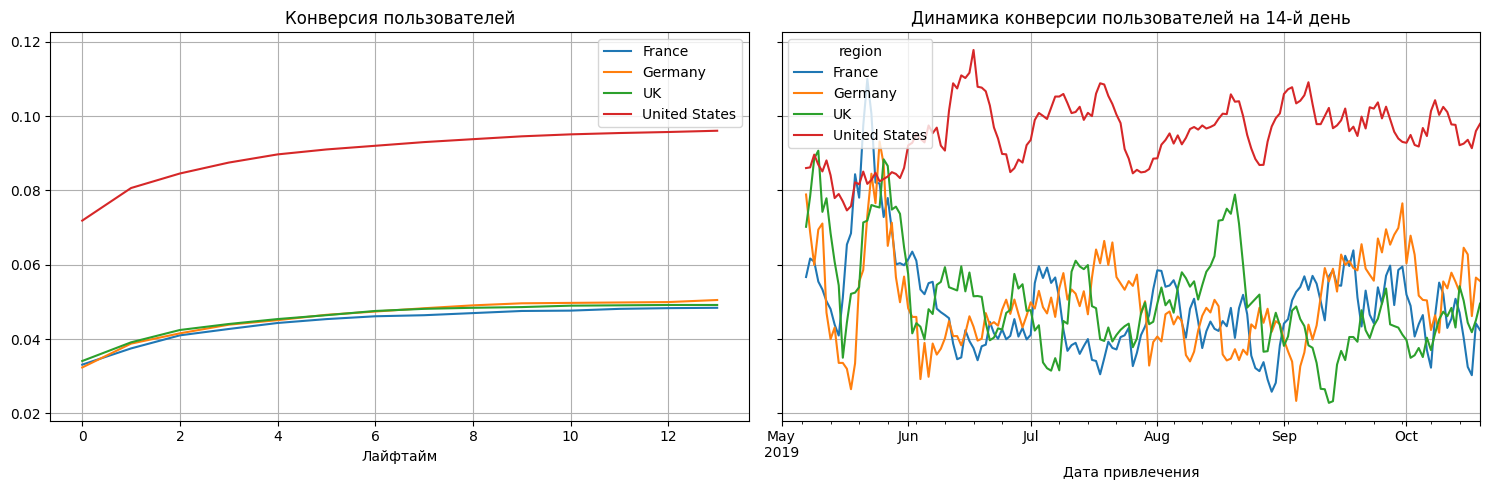

In [49]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- В целом конверсия пользователей из всех стран растет. Лучше всего конвертируются пользователи из США. Пользователи из остальных стран конвертируются примерно на одном уровне и примерно в 2 раза хуже, чем пользователи из США
- Конверсия пользователей 14-го дня меняется со временем. Пользователи из Франции, Великобритании и Германии конвертировались лучше, чем пользователи из США в конце мая. После этого периода пользователи 14-го дня из США стали конвертироваться лучше пользователей из других стран.


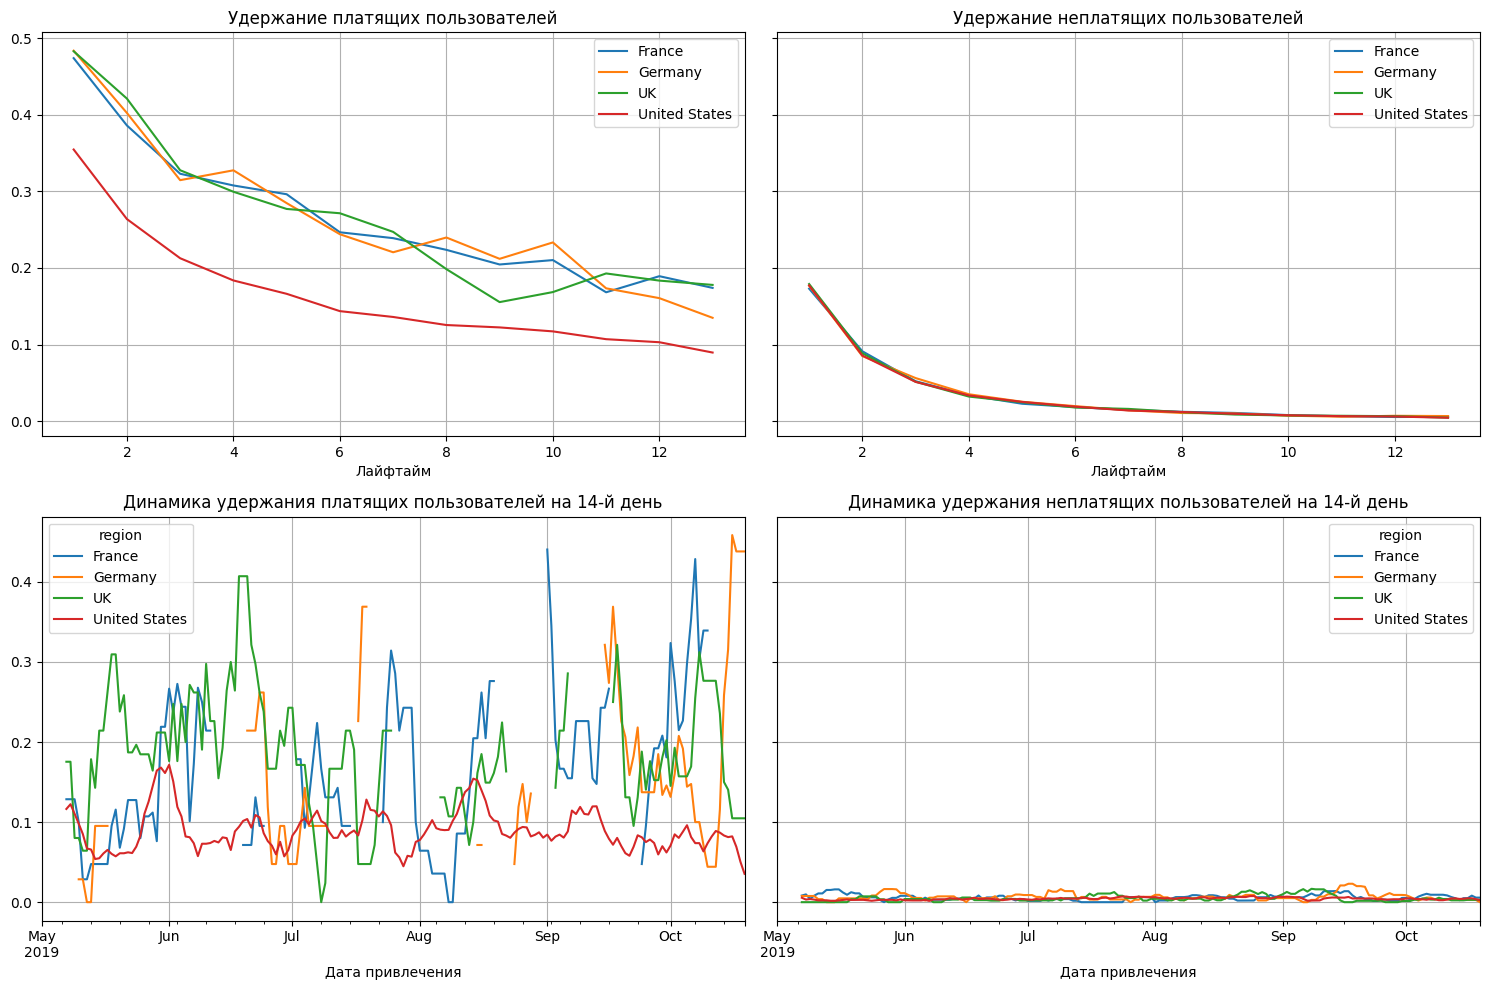

In [50]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание пользователей из Германии, Франции и Великобртании примерно на одном уровне. Хуже всего удерживаются пользователи США.
- Удержание платящих пользователй лучше, чем неплатящих.
- Платящие пользователи 14-го дня с Франции перестают возвращаться в приложение в середине июня, в конце июня, в конце августа, в октябре : это видно по разрывам на графике. 
- То же самое можно сказать о пользователях 14-го дня из Германии. Они очень плохо возвращаются в приложение. 
- А вот пользователи из США 14-го дня стабильно возвращаются в приложение, разрывов на графике не наблюдается.

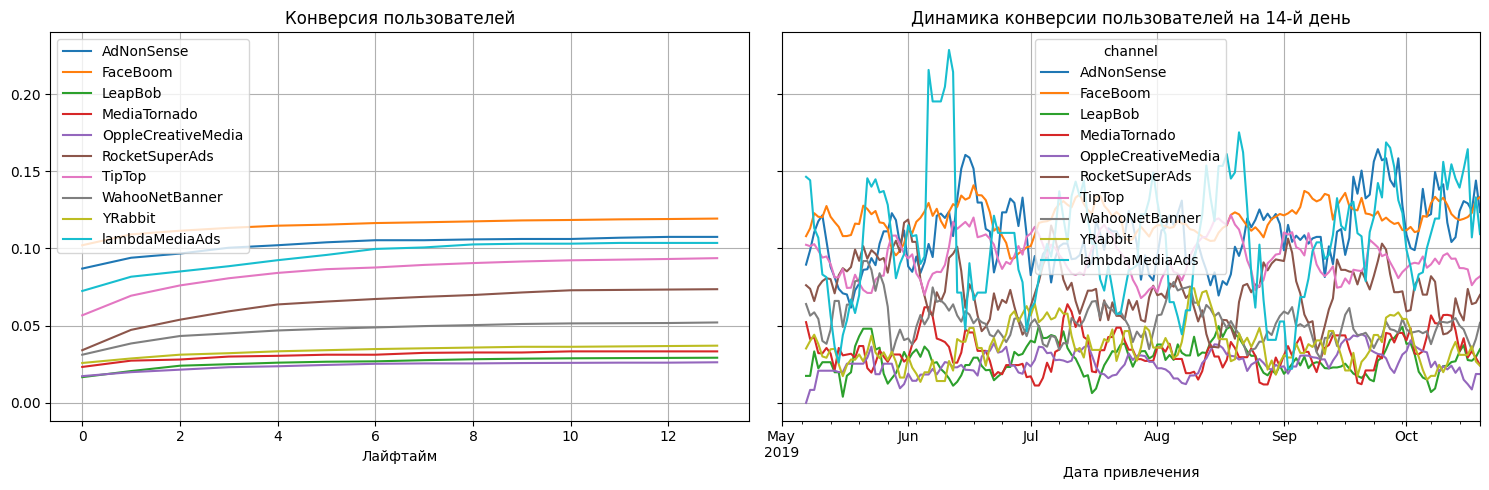

In [51]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей, привлеченных из платных источников, очень плохо растет: она практически остается на одном уровне со временем. 

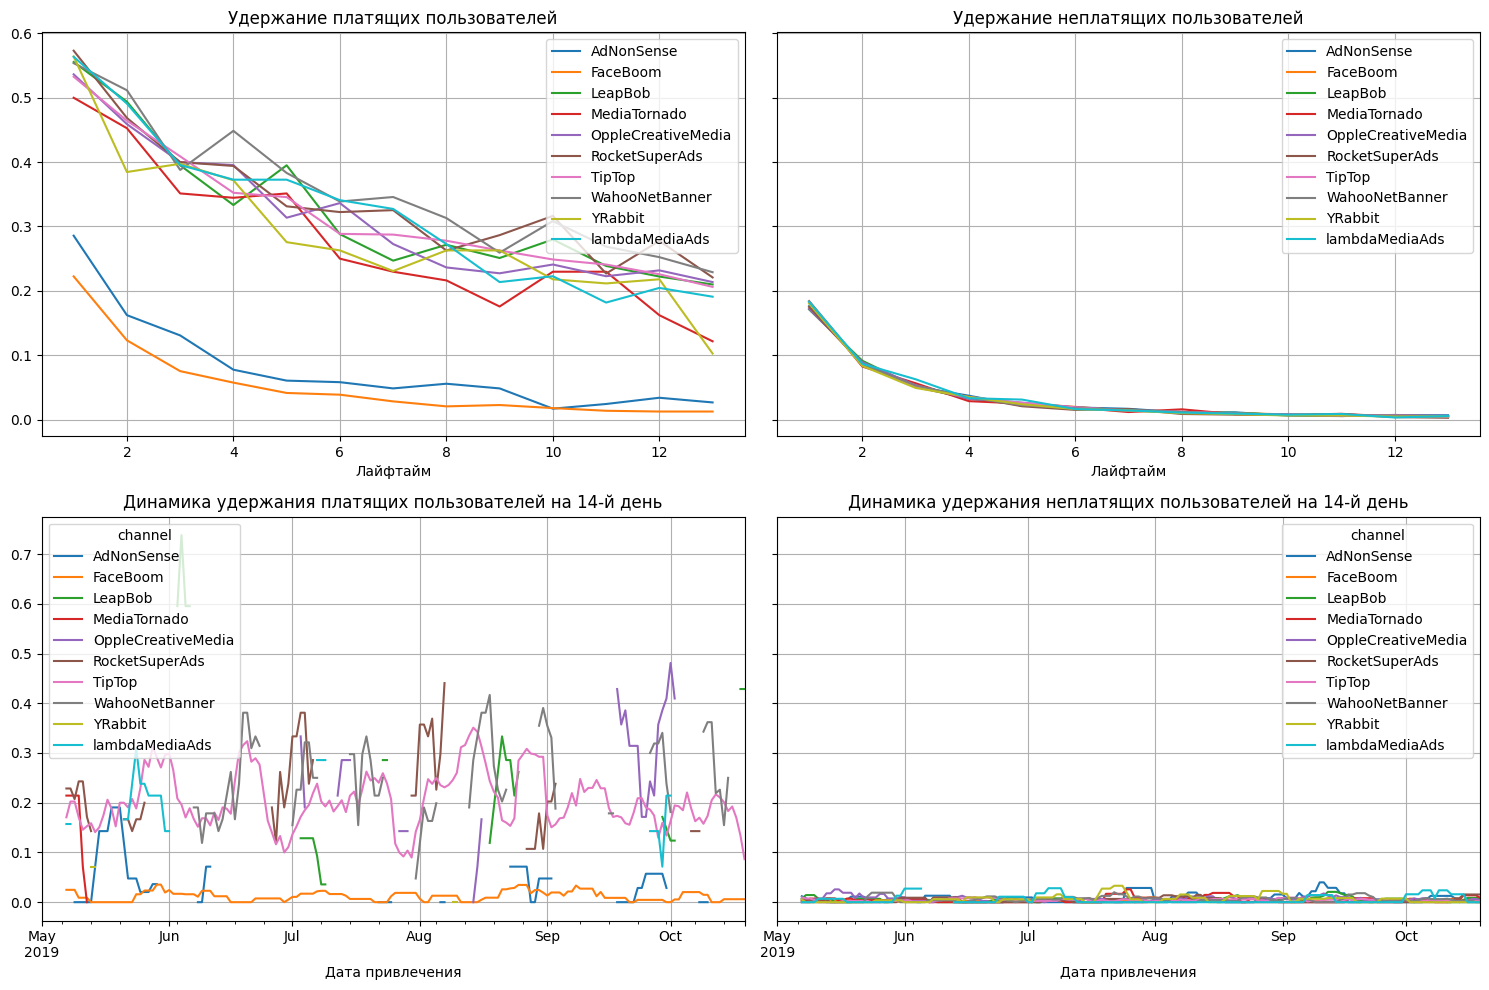

In [52]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Самое низкое удержание пользователей из каналов AdNonSence и FaceBoom. Эти платящие пользователи удерживаются даже хуже, чем неплатящие пользователи.
- Касаемо динамики удержания платящих пользователей 14-го дня, то можно сказать, что только пользователи из FaceBoom  TipTop продолжают стабильно заходить в приложение. Все остальные пользователи либо вообще не заходят в приложение, либо заходят крайне мало.

# Выводы

Причины неэффективности привлечения пользователей:
- Низкое удержание пользователей iPhone, Mac из США 
- Огромные вложения на рекламу в TipTop, которые вообще никак не окупаются.
    
Рекомендации:
- Снизить затраты на привлечение пользователей iPhone и Mac
- Повысить затраты на привлечение пользователец PC
- Снизить затраты на рекламу пользователям из США
- Исключить рекламные каналы AdNonSence и FaceBoom
- Нужно вложиться в канал YRabbit, т.к. он лучше всего показал себя по окупаемости и в динамике ROI на 14-й день, также у пользователей из этого источника неплохая конверсия (наравне с другими источниками) и удержание лучше, чем у TipTop И AdNonSence